In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
%matplotlib inline

In [3]:
sns.set_style('darkgrid')

In [4]:
conn = psycopg2.connect("dbname='FVSOut' user='postgres' host='localhost' port='5433'") # password in pgpass file
SQL = '''
SELECT parcel.parcelid, SUM(acres) AS acres, SUM(baucore) AS core_bau, SUM(fsccore) AS core_fsc,
    SUM(nonrip_fsc) AS nonrip_fsc, SUM(nonrip_bau) AS nonrip_bau, state
FROM parcel, state
WHERE parcel.standid = state.standid AND parcel.parcelid NOT IN (26, 31, 39)
GROUP BY parcel.parcelid, state.state;
'''
# read the query into a pandas dataframe
parcels = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [5]:
parcels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 7 columns):
parcelid      64 non-null int64
acres         64 non-null float64
core_bau      64 non-null float64
core_fsc      64 non-null float64
nonrip_fsc    64 non-null float64
nonrip_bau    64 non-null float64
state         64 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 3.6+ KB


In [6]:
parcels.head()

,parcelid,acres,core_bau,core_fsc,nonrip_fsc,nonrip_bau,state
0,51,575.7,8.50,28.09,547.86,550.49,WA
1,12,135.7,0.27,11.28,124.12,134.94,OR
2,53,3668.3,44.46,84.95,3583.24,3583.24,OR
3,49,18.6,0.00,0.00,18.69,18.69,WA
4,33,632.8,11.16,47.66,585.07,604.22,WA


In [7]:
parcels['rip_fsc'] = parcels.acres - parcels.nonrip_fsc
parcels['rip_bau'] = parcels.acres - parcels.nonrip_bau
parcels['pctrip_fsc'] = parcels.rip_fsc / parcels.acres
parcels['pctrip_bau'] = parcels.rip_bau / parcels.acres
parcels['pctcore_fsc'] = parcels.core_fsc / parcels.acres
parcels['pctcore_bau'] = parcels.core_bau / parcels.acres

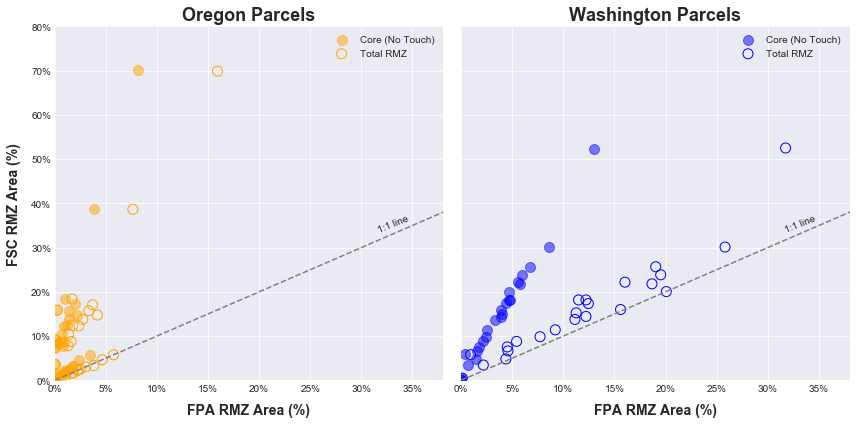

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)
parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=100, alpha=0.5,
                                                ax=axs[0], label='Core (No Touch)', color='orange', )
parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=100,
                                               ax=axs[0], label='Total RMZ', c='none', edgecolors='orange')
axs[0].set_title('Oregon Parcels', weight='bold', fontsize=18)

parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=100, alpha=0.5,
                                                ax=axs[1], label='Core (No Touch)', color='blue')
parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=100, 
                                               ax=axs[1], label='Total RMZ', c='none', edgecolors='blue')
axs[1].set_title('Washington Parcels', weight='bold', fontsize=18)

for ax in axs:
    ax.set_ylabel('FSC RMZ Area (%)', weight='bold', labelpad=10, fontsize=14)
    ax.set_xlabel('FPA RMZ Area (%)', weight='bold', labelpad=10, fontsize=14)
    ax.set_xlim(-0.02,0.38)
    ax.set_ylim(0.02,0.8)
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='gray', linestyle='--')
    ax.text(0.315,0.36, '1:1 line', rotation=22)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('FVSvFPA_RMZcore.png');

In [9]:
# data = pd.read_csv('C:/GitHub/FSC_Case_Studies/Data/rxAll.csv')

conn = psycopg2.connect("dbname='FVSOut' user='postgres' host='localhost' port='5433'") # password in pgpass file
SQL = '''
SELECT *
FROM rxall
WHERE parcel NOT IN (26, 31, 39);
'''
# read the query into a pandas dataframe
data = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [10]:
# join with the parcel table to get the state for each parcel
data = pd.merge(left=data, right=parcels[['parcelid', 'state']], left_on='parcel', right_on='parcelid').drop('parcelid', axis=1)
data = data.sort_values(by=['parcel', 'rx', 'year'])

# rename some of the scenarios to intuitive names
data['scenario'] = data.rx.replace(to_replace={'BAU':'BAU', 'FSC':'SHORT~FSC', 'BAU_long':'LONG~FPA', 'FSC_long':'LONG~FSC'})

In [11]:
# calculate carbon stored in trees
data['tree_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead 

In [12]:
data.head()

,parcel,year,cumulative_mbf,aboveground_total_live,aboveground_merch_live,belowground_live,standing_dead,forest_down_dead_wood,forest_floor,forest_shrub_herb,...,nfv_adj,undiscounted_cost_adj,discounted_cost_adj,undiscounted_revenue_adj,discounted_revenue_adj,mrch_boardfoot_volume_adj,rx,state,scenario,tree_carbon
0,1,2014,15.970034,9.017713,6.250068,2.132380,0.062337,14.282286,7.503778,0.810015,...,6956.568805,5586.189700,5546.269526,12542.75849,11945.47997,15970.034020,BAU,OR,BAU,11.212429
1,1,2019,18.796406,5.457526,3.079071,1.022616,0.062179,9.769980,6.528582,0.957059,...,8021.127219,6756.847904,6446.510345,14777.97509,13613.43361,2826.371926,BAU,OR,BAU,6.542322
2,1,2024,19.051407,6.633055,3.646654,1.473734,0.097222,7.944706,6.266200,0.493398,...,7965.319402,7015.635684,6595.630861,14980.95505,13732.11181,255.000966,BAU,OR,BAU,8.204011
3,1,2029,19.218172,10.402675,4.352607,2.495856,0.141841,6.751062,6.214097,0.221037,...,7867.200352,7246.502753,6699.021584,15113.70307,13792.92540,166.765681,BAU,OR,BAU,13.040371
4,1,2034,19.604465,19.059874,11.183316,4.169119,0.191972,5.821740,6.284404,0.207456,...,7870.711659,7550.487572,6807.530854,15421.19920,13903.29880,386.293128,BAU,OR,BAU,23.420965


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10240 entries, 0 to 10219
Data columns (total 36 columns):
parcel                       10240 non-null int64
year                         10240 non-null int64
cumulative_mbf               10240 non-null float64
aboveground_total_live       10240 non-null float64
aboveground_merch_live       10240 non-null float64
belowground_live             10240 non-null float64
standing_dead                10240 non-null float64
forest_down_dead_wood        10240 non-null float64
forest_floor                 10240 non-null float64
forest_shrub_herb            10240 non-null float64
total_stand_carbon           10240 non-null float64
total_removed_carbon         10240 non-null float64
carbon_released_from_fire    10240 non-null float64
products                     10240 non-null float64
landfill                     10240 non-null float64
energy                       10240 non-null float64
emissions                    10240 non-null float64
merch_carbo

### Implementing California Air Resources Board accounting for harvest wood products.

We will folllow the California ARB accounting approach for carbon storage in wood products. 

The 2015 California ARB [Forest Carbon Offset Project Protocol](https://www.arb.ca.gov/cc/capandtrade/protocols/usforest/usforestprojects_2015.htm) accounts for carbon stored in products by defining the disposition of removed marchantable carbon into the products pool over time.

In the Western Cascades "Assessment Area", the ARB protocol specifies the following factors:

| Description | Softwood Lumber | Hardwood Lumber | Plywood | Oriented Strand Board | Non-structural Panels | Miscellaneous | Paper |
|---|---|---|---|---|---|---|---|
| % in each class | 75.3% | 4.3% | 11.4% | 0.0% | 0.1% | 0.5% | 8.4% |
| 100-yr avg. storage | 46.3% | 25.0% | 48.4% | 58.2% | 38.0% | 17.6% | 5.8% |
| avg. storage in in-use products | 34.9% | 1.1% | 5.5% | 0.0% | 0.0% | 0.1% | 0.5% |

The sum of merchantable carbon removed that remains across product categories (averaged over 100 years) is __42.1%__. We will apply this proportion to the volume of carbon in the merchantable portions of trees removed over time.

In [14]:
data['ARBhwp'] = data.merch_carbon_removed * 0.421

### Implementing California Air Resources Board accounting for market effects leakage.

We will folllow the California ARB accounting approach to account for the displacement of harvesting outside the "project area". 

The 2015 California ARB [Forest Carbon Offset Project Protocol](https://www.arb.ca.gov/cc/capandtrade/protocols/usforest/usforestprojects_2015.htm) describes market leakage as "Secondary Effects Emissions," which is calculated as:

If $\sum\limits_{n=1}^{y} AC_{se,n} - BC_{se,n} >= 0 $: then  $SE_y = 0$

If $\sum\limits_{n=1}^{y} AC_{se,n} - BC_{se,n} < 0 $: then $SE_y = (AC_y - BC_y) * 0.20 $

Where,<br>
$SE_y$ = Estimated annual secondary effects (MT $CO_2e$)<br>
$y$ = The reporting period<br>
$AC_{se,n}$ = Actual amount of carbon in standing live and standing dead trees (whole tree including belowground biomass and bark) harvested by reporting period $y$<br>
$BC_{se,n}$ = Estimated average baseline amount of carbon in standing live and standing dead trees (whole tree including belowground biomass and bark) that would have been harvested by reporting period $y$



In [15]:
# FVS outputs total_removed_carbon in the FVS_Carbon report as the amount of above-ground carbon removed each period
# To follow the ARB requirement to also account for belowground carbon in harvested trees, we'll need to update the FVS output

# the ratio of amount of "tree carbon" (above- and below-ground live + standing dead) to above-ground tree carbon
ratio = data.tree_carbon/(data.aboveground_total_live + data.standing_dead)

data['periodic_removed_carbon_alltree'] = data.total_removed_carbon * ratio

# now calculate the cumulative amount of total removed carbon
cols = ['parcel', 'rx', 'year', 'periodic_removed_carbon_alltree']
data['cumulative_removed_carbon_alltree'] = data[cols].groupby(by=['parcel', 'rx']).cumsum()['periodic_removed_carbon_alltree']

In [16]:
def calc_leakage(row):
    '''
    For each row in the data, looks up the amount of harvested carbon under the BAU scenario 
    for the same parcel and year, and then calculates market effects leakage per the ARB protocol.
    '''
    bau_mask = (data.rx == 'BAU') & (data.year == row.year) & (data.parcel == row.parcel)
    bau_removed = data.loc[bau_mask, 'periodic_removed_carbon_alltree'].values[0]
    bau_cum_removed = data.loc[bau_mask, 'cumulative_removed_carbon_alltree'].values[0]
    
    if row.cumulative_removed_carbon_alltree < bau_cum_removed :
        leakage = (row.periodic_removed_carbon_alltree - bau_removed) * 0.20
    
    else:
        leakage = 0
        
    return leakage

In [17]:
data['leakage'] = data[['parcel', 'rx', 'year', 'periodic_removed_carbon_alltree', 'cumulative_removed_carbon_alltree']].apply(calc_leakage, axis=1)
cols = ['parcel', 'rx', 'year', 'leakage']
data['cumulative_leakage'] = data[cols].groupby(by=['parcel', 'rx']).cumsum()['leakage']

In [18]:
# calculate carbon stored in the forest and in wood products
data['tree_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead 
data['tot_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead + data.ARBhwp + data.leakage
data['tCO2e'] = data.tot_carbon * 44/12

In [19]:
# calculate cumulative volume removals and total standing + removed volumes
vol_cols = ['rbdft', 'rcuft', 'rmcuft']
cum_removals = data.groupby(by=['parcel', 'rx', 'year']).sum().groupby(level=[0,1])[vol_cols].cumsum()
data.set_index(['parcel', 'rx', 'year'], inplace=True)
data['cumulative_rbdft'] = cum_removals['rbdft']
data['cumulative_rcuft'] = cum_removals['rcuft']
data['cumulative_rmcuft'] = cum_removals['rmcuft']
data.reset_index(inplace=True)
data['stand_plus_remove_bdft'] = data.bdft + data.cumulative_rbdft
data['stand_plus_remove_cuft'] = data.tcuft + data.cumulative_rcuft
data['stand_plus_remove_mcuft'] = data.mcuft + data.cumulative_rmcuft

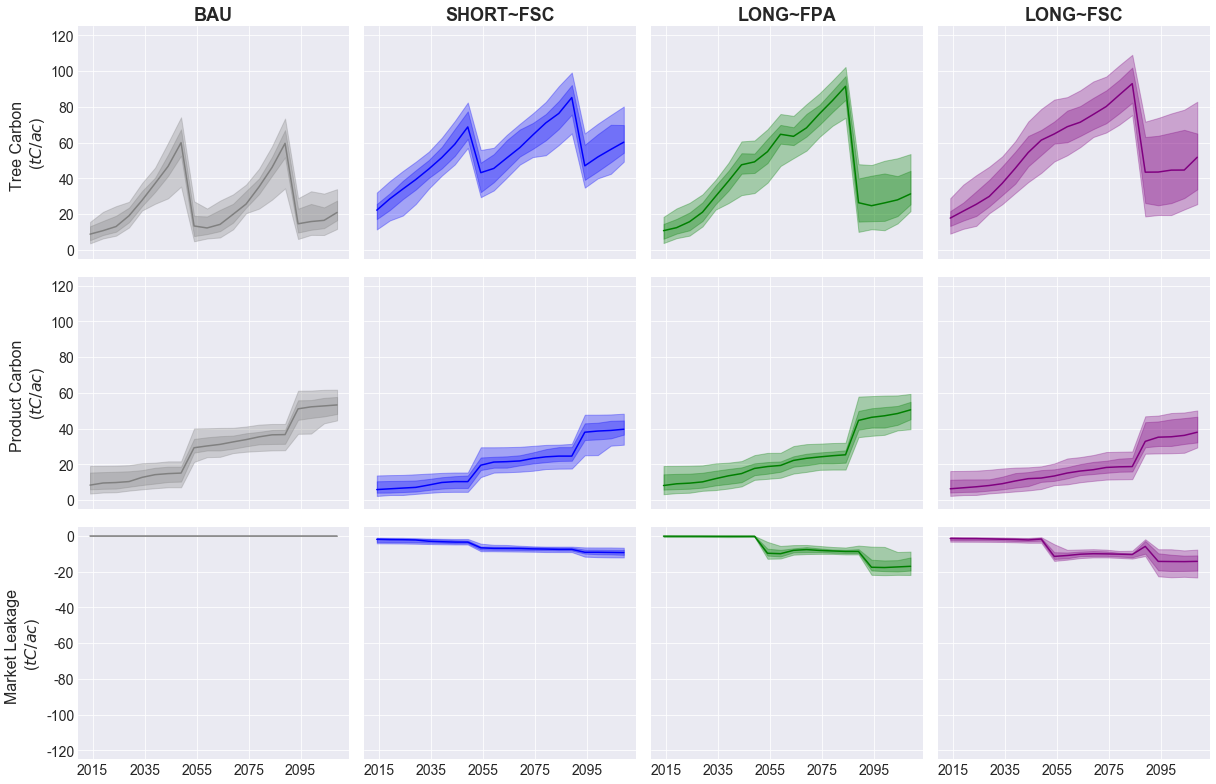

In [20]:
colors = ['gray', 'blue', 'green', 'purple']
pal = colors


fig, axs = plt.subplots(3,4, figsize=(17,11), sharex=True, sharey='row')
cols = ['parcel', 'year', 'scenario', 'tree_carbon', 'ARBhwp', 'cumulative_leakage']
metrics = ['tree_carbon', 'ARBhwp', 'cumulative_leakage']
scenarios = ['BAU', 'SHORT~FSC', 'LONG~FPA', 'LONG~FSC']
yaxis_labels = ['''Tree Carbon 
($tC/ac$)''',
                '''Product Carbon 
($tC/ac$)''',
                '''Market Leakage 
($tC/ac$)''']

i=0
for metric in metrics:
    parcels = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','year']).quantile([0, 0.10,0.25,0.50,0.75,0.90, 1.0])[metric].unstack(level=-1)
    pivot = pd.pivot_table(parcels.reset_index(), index='year', columns='scenario', values=[0,0.10,0.25,0.50,0.75,0.90,1])
    pivot = pivot.sort_index(axis=1, ascending=False)
    axs[i][0].set_ylabel(metric, fontsize=14) # label y-axis on first graph
    
    # plot the bands
    for j in range(len(scenarios)):
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.10][scenarios[j]], 
                              y2=pivot[0.90][scenarios[j]],
                              alpha=0.3, color=pal[j])
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.25][scenarios[j]], 
                              y2=pivot[0.75][scenarios[j]],
                              alpha=0.3, color=pal[j])
        axs[i][j].plot(pivot[0.5][scenarios[j]], lw=1.5, color=pal[j])    
    i+=1

# label the plots
for i in range(len(axs[0])):
    axs[0][i].set_title(scenarios[i], fontsize=18, weight='bold') # label title on top row
    axs[-1][i].xaxis.set_tick_params(labelsize=14) # ticks on bottom row

for i in range(len(axs)):
    axs[i][0].set_ylabel(yaxis_labels[i], fontsize=16) # axis label on first column
    axs[i][0].yaxis.set_major_formatter(FuncFormatter('{0:,.0f}'.format))
    axs[i][0].yaxis.set_tick_params(labelsize=14)
    axs[i][0].set_ylim(-5, 125)
                               
# set products to be on same axis range as leakage
tree_min, tree_max = axs[0][0].get_ylim() 
axs[1][0].set_ylim(tree_min, tree_max)
axs[2][0].set_ylim(-tree_max, -tree_min)

plt.setp(axs, xticks=range(2015,2115,20))
plt.tight_layout()
plt.savefig('carbon_pools.png');

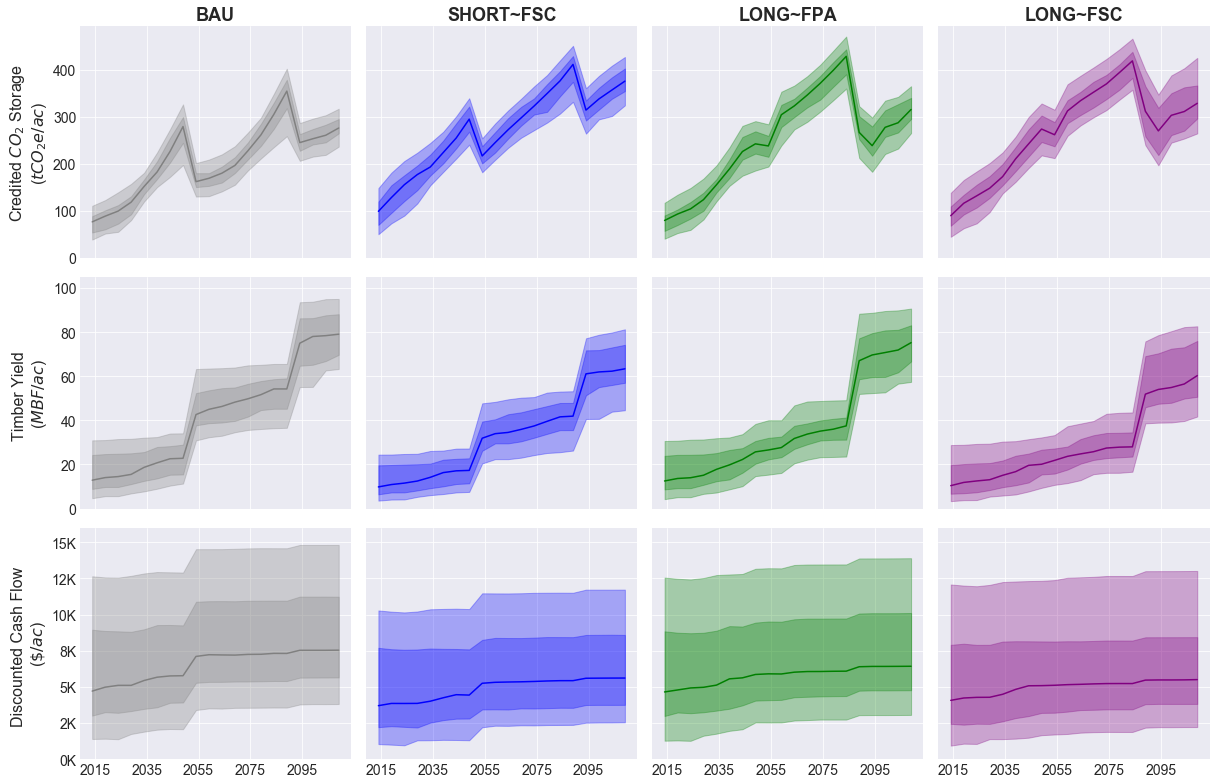

In [21]:
colors = ['gray', 'blue', 'green', 'purple']
pal = colors

fig, axs = plt.subplots(3,4, figsize=(17,11), sharex=True, sharey='row')
cols = ['parcel', 'year', 'scenario', 'tCO2e', 'cumulative_mbf', 'npv_adj']
metrics = ['tCO2e', 'cumulative_mbf', 'npv_adj']
scenarios = ['BAU', 'SHORT~FSC', 'LONG~FPA', 'LONG~FSC']
yaxis_labels = ['''Credited $CO_2$ Storage 
($tCO_2e/ac$)''', 
                '''Timber Yield 
($MBF/ac$)''',
                '''Discounted Cash Flow 
($\$/ac$)''']

i=0
for metric in metrics:
    parcels = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','year']).quantile([0, 0.10,0.25,0.50,0.75,0.90, 1.0])[metric].unstack(level=-1)
    pivot = pd.pivot_table(parcels.reset_index(), index='year', columns='scenario', values=[0,0.10,0.25,0.50,0.75,0.90,1])
    pivot = pivot.sort_index(axis=1, ascending=False)
    axs[i][0].set_ylabel(metric, fontsize=14) # label y-axis on first graph
    
    # plot the bands
    for j in range(len(scenarios)):
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.10][scenarios[j]], 
                              y2=pivot[0.90][scenarios[j]],
                              alpha=0.3, color=pal[j])
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.25][scenarios[j]], 
                              y2=pivot[0.75][scenarios[j]],
                              alpha=0.3, color=pal[j])
        axs[i][j].plot(pivot[0.5][scenarios[j]], lw=1.5, color=pal[j])    
    i+=1

# label the plots
for i in range(len(axs[0])): # go by rows
    axs[0][i].set_title(scenarios[i], fontsize=18, weight='bold') # label title on top row
    axs[-1][i].xaxis.set_tick_params(labelsize=14) # ticks on bottom row

for i in range(len(axs)): # go by columns
    axs[i][0].set_ylabel(yaxis_labels[i], fontsize=16) # axis label on first column
    axs[i][0].yaxis.set_major_formatter(FuncFormatter('{0:,.0f}'.format))
    axs[i][0].yaxis.set_tick_params(labelsize=14)
    

axs[1][0].set_ylim(0, 105)
axs[2][0].set_ylim(0, 16000)

def currency(x, pos):
    return '{:1.0f}K'.format(x*1e-3)

axs[-1][0].yaxis.set_major_formatter(FuncFormatter(currency))
                               
plt.setp(axs, xticks=range(2015,2115,20))
plt.setp(axs[0], yticks=range(0,500,100)) # credited tco2e yticks
plt.setp(axs[1], yticks=range(0,120,20)) # timber yield yticks
plt.setp(axs[2], yticks=range(0,17500,2500), xlabel='') # cash flow yticks

plt.tight_layout()
plt.savefig('KPI_lins.png');

In [22]:
cols = ['parcel', 'year', 'state', 'scenario', 'cumulative_mbf', 'tCO2e', 'npv_adj']
all_rx = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','parcel','state']).agg({'cumulative_mbf':'max', 'tCO2e':'mean', 'npv_adj':'max'})
all_rx['tCO2e_MBF'] = all_rx.tCO2e / all_rx.cumulative_mbf

In [23]:
long_fpa = all_rx.xs('LONG~FPA') - all_rx.xs('BAU')
long_fsc = all_rx.xs('LONG~FSC') - all_rx.xs('BAU')
short_fsc = all_rx.xs('SHORT~FSC') - all_rx.xs('BAU')
long_fpa_pct = (all_rx.xs('LONG~FPA') - all_rx.xs('BAU'))/all_rx.xs('BAU')
long_fsc_pct = (all_rx.xs('LONG~FSC') - all_rx.xs('BAU'))/all_rx.xs('BAU')
short_fsc_pct = (all_rx.xs('SHORT~FSC') - all_rx.xs('BAU'))/all_rx.xs('BAU')

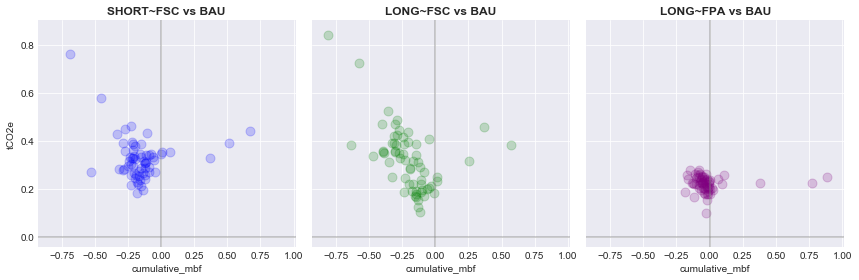

In [24]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True)
scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
titles = ['SHORT~FSC vs BAU', 'LONG~FSC vs BAU', 'LONG~FPA vs BAU']
colors = ['blue', 'green', 'purple']
for i in range(3):
    scenarios[i].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)
    axs[i].axhline(y=0, color='grey', alpha=0.5)
    axs[i].axvline(x=0, color='grey', alpha=0.5)
    axs[i].set_title(titles[i], weight='bold')
plt.tight_layout();

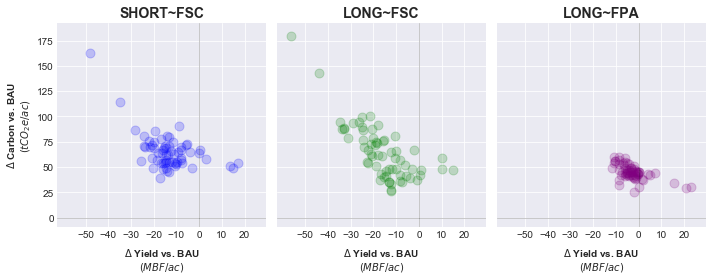

In [25]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc, long_fsc, long_fpa]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)

    axs[i].set_xlabel('''$\Delta$ Yield vs. BAU
$(MBF/ac)$''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')

#axs[0].set_ylim(-5,200)
axs[0].set_xticks(range(-50,25, 10))
axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
$(tCO_2e/ac)$''', weight='bold')

plt.tight_layout()
plt.savefig('scenario_scatter_carbontimber.png');

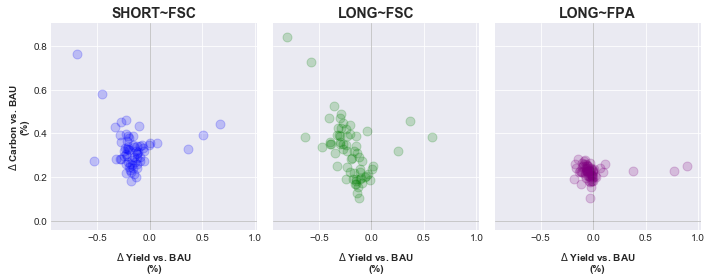

In [26]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)

    axs[i].set_xlabel('''$\Delta$ Yield vs. BAU
(%)''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')
#axs[0].set_ylim(-5,200)
axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
(%)''', weight='bold')
plt.tight_layout()
plt.savefig('scenario_scatter_carbontimber_percent.png');

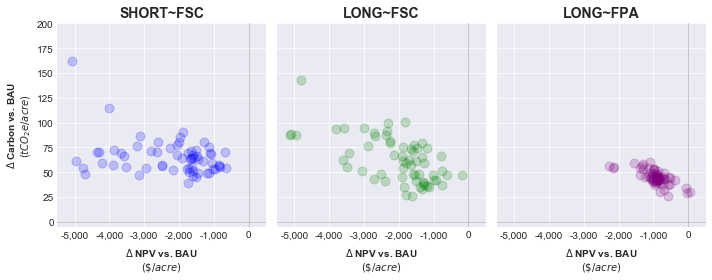

In [27]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc, long_fsc, long_fpa]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='npv_adj', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)
    axs[i].xaxis.set_major_formatter(FuncFormatter('{:,.0f}'.format))

    axs[i].set_xlabel('''$\Delta$ NPV vs. BAU
$(\$/acre)$''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')
axs[0].set_ylim(-5,200)
axs[0].set_xlim(-5500,500)
axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
$(tCO_2e/acre)$''', weight='bold')
plt.tight_layout()
plt.savefig('scenario_scatter_carboncash.png');

In [28]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'tCO2e_MBF':'{:.2f}', 'lca_tCO2e': '{:,.0f}', 'lca_tCO2e_MBF':'{:.2f}'}
all_rx.reset_index().groupby(by=['state', 'scenario']).mean().drop('parcel', axis=1).style.format(styles)

In [29]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'tCO2e_MBF':'{:.2f}', 'lca_tCO2e': '{:,.0f}', 'lca_tCO2e_MBF':'{:.2f}'}
all_rx.reset_index().groupby(by=['state', 'scenario']).quantile([0.10, 0.90]).drop('parcel', axis=1).style.format(styles)

## Tables of differences between alternative scenarios vs. BAU

### LONG~FSC

In [30]:
long_fsc_pct.groupby(level=1).mean().style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
state,,,,
OR,-17.1%,31.0%,-26.9%,83.1%
WA,-23.9%,33.8%,-31.8%,86.1%


In [31]:
long_fsc_pct.groupby(level=1).quantile([0.10, 0.90]).style.format("{:.1%}")

In [32]:
# absolute difference between FSC-LONG and BAU
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
long_fsc.groupby(level=1).mean().style.format(styles)

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
state,,,,
OR,-15.0,60,"$-2,013",2.20019
WA,-18.0,71,"$-2,257",2.65872


In [33]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
long_fsc.groupby(level=1).quantile([0.10, 0.90]).style.format(styles)

In [34]:
# ignoring state differences
pd.DataFrame(long_fsc_pct.mean()).T.style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
0,-19.8%,32.1%,-28.8%,84.3%


In [35]:
long_fsc_pct.quantile([0.10, 0.90]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
0.1,-39.0%,18.1%,-44.7%,25.0%
0.9,-3.5%,45.4%,-11.5%,123.8%


### SHORT~FSC

In [36]:
short_fsc_pct.groupby(level=1).mean().style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
state,,,,
OR,-15.1%,33.4%,-27.1%,69.5%
WA,-15.9%,31.2%,-27.4%,60.7%


In [37]:
short_fsc_pct.groupby(level=1).quantile([0.10, 0.90]).style.format("{:.1%}")

In [38]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
short_fsc.groupby(level=1).mean().style.format(styles)

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
state,,,,
OR,-13.8,65,"$-2,350",1.77747
WA,-12.7,65,"$-2,045",1.80642


In [39]:
# absolute difference between FSC-SHORT and BAU
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
short_fsc.groupby(level=1).quantile([0.10, 0.90]).style.format(styles)

In [40]:
# ignoring state differences
pd.DataFrame(short_fsc_pct.mean()).T.style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
0,-15.4%,32.5%,-27.2%,66.1%


In [41]:
short_fsc_pct.quantile([0.10, 0.90]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
0.1,-28.2%,24.0%,-35.9%,36.1%
0.9,-5.1%,41.9%,-18.9%,89.1%


### LONG~FPA

In [42]:
long_fpa_pct.groupby(level=1).mean().style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
state,,,,
OR,1.4%,21.5%,-12.8%,22.4%
WA,-6.1%,23.6%,-17.0%,33.0%


In [43]:
long_fpa_pct.groupby(level=1).quantile([0.10, 0.90]).style.format("{:.1%}")

In [44]:
# absolute difference between FPA-LONG and BAU
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
long_fpa.groupby(level=1).mean().style.format(styles)

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
state,,,,
OR,-1.3,42,$-831,0.513922
WA,-5.2,49,"$-1,116",0.962962


In [45]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_adj':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
long_fpa.groupby(level=1).quantile([0.10, 0.90]).style.format(styles)

In [46]:
# ignoring state differences
pd.DataFrame(long_fpa_pct.mean()).T.style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
0,-1.5%,22.3%,-14.5%,26.6%


In [47]:
long_fpa_pct.quantile([0.10, 0.90]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,tCO2e_MBF
0.1,-11.8%,18.2%,-23.0%,17.0%
0.9,2.2%,25.9%,-5.4%,40.0%


## Calculate the timber value premium that would be required for the alternative scenarios to match the NPV of BAU

In [48]:
from scipy.optimize import minimize

In [49]:
# get the incremental undiscounted timber revenue and cost for each parcel over time
def get_npv_diff(timber_premium=0.0, parcelid=1, scenario='SHORT~FSC'):
    cols = ['scenario', 'year', 'parcel', 'undiscounted_revenue_adj', 'undiscounted_cost_adj']
    parcel = data[cols].loc[(data.scenario == scenario) & (data.parcel == parcelid)]
    bau_npv = data.loc[(data.scenario == 'BAU') & (data.parcel == parcelid)]['npv_adj'].iloc[-1]
    periodic = parcel.groupby(by=['scenario', 'parcel']).diff()
    periodic['undiscounted_cost_adj'].iloc[0] = parcel['undiscounted_cost_adj'].iloc[0]
    periodic['undiscounted_revenue_adj'].iloc[0] = parcel['undiscounted_revenue_adj'].iloc[0]
    periodic['year'] = parcel['year']

    # apply a premium value to the timber revenue for the FSC scenario
    periodic['undiscounted_premium'] = timber_premium * periodic.undiscounted_revenue_adj
    
    # then calculate cumulative NPV
    periodic['discounted_cost'] = periodic.undiscounted_cost_adj/((1+0.05)**(periodic.year-2014))
    periodic['discounted_revenue_premium'] = (periodic.undiscounted_premium + periodic.undiscounted_revenue_adj)/((1+0.05)**(periodic.year-2014))
    periodic['npv_premium'] = periodic.discounted_revenue_premium - periodic.discounted_cost
    # sum up the periodic net values to get cumulative NPV
    prem_npv = periodic.npv_premium.sum()
    
    # and finally calculates the NPV difference vs. BAU after 100 years for each property
    return (bau_npv - prem_npv)**2

In [78]:
# run an optimization on each parcel to determine the timber premium at which 
# the difference in NPV from BAU is minimized

parcelids = pd.unique(data.parcel)
timber_premium_dict = {}
for scenario in ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']:
    print(scenario, end=': ')
    timber_premium_dict[scenario] = {}
    for parcelid in parcelids:
        result = minimize(get_npv_diff, x0=0.1, args=(parcelid, scenario), bounds=[(0,5)])
        timber_premium_dict[scenario][parcelid] = result.x[0]
        print(parcelid, end=', ')

SHORT~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FPA: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 

In [79]:
state_lookup = data[['parcel', 'state','year']].groupby(by=['parcel', 'state']).mean().reset_index(level=1)['state']

In [80]:
timber_parcels = [parcel for parcel in parcelids]
timber_states = [state_lookup[parcel] for parcel in parcelids]
timber_fscshort = [timber_premium_dict['SHORT~FSC'][parcel] for parcel in parcelids]
timber_fsclong = [timber_premium_dict['LONG~FSC'][parcel] for parcel in parcelids]
timber_fpalong = [timber_premium_dict['LONG~FPA'][parcel] for parcel in parcelids]

timber_data = {'state': timber_states, 'parcel':timber_parcels, 'SHORT~FSC':timber_fscshort, 
               'LONG~FSC':timber_fsclong, 'LONG~FPA':timber_fpalong}
timber_premiums = pd.DataFrame(timber_data)

In [81]:
timber_premiums.groupby('state').mean()[['SHORT~FSC','LONG~FSC','LONG~FPA']].style.format('{:.1%}')

,SHORT~FSC,LONG~FSC,LONG~FPA
state,,,
OR,14.7%,18.0%,2.8%
WA,13.6%,19.6%,6.0%


In [83]:
timber_premiums.groupby('state').quantile([0, 0.1, 0.5, 0.9, 1])[['SHORT~FSC','LONG~FSC','LONG~FPA']].style.format('{:.1%}')

In [84]:
pd.DataFrame(timber_premiums[['SHORT~FSC','LONG~FSC', 'LONG~FPA']].mean()).T.style.format('{:.1%}')

,SHORT~FSC,LONG~FSC,LONG~FPA
0,14.3%,18.6%,4.1%


In [85]:
timber_premiums[['SHORT~FSC','LONG~FSC', 'LONG~FPA']].quantile([0.10, 0.90]).style.format("{:.1%}")

,SHORT~FSC,LONG~FSC,LONG~FPA
0.1,6.9%,2.5%,0.0%
0.9,18.9%,30.6%,8.7%


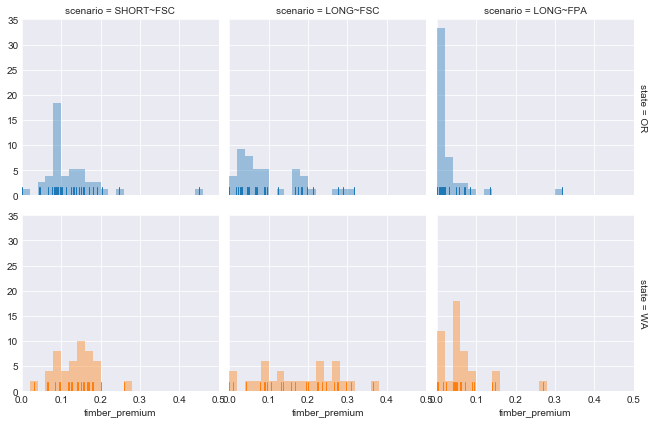

In [159]:
timber_melt = pd.melt(timber_premiums, id_vars=['state', 'parcel'], value_vars=['SHORT~FSC', 'LONG~FSC', 'LONG~FPA'], var_name='scenario', value_name='timber_premium')
g = sns.FacetGrid(timber_melt, row='state', hue="state", col="scenario", margin_titles=True)
bins = np.arange(0,1,.02)
g.map(sns.distplot, 'timber_premium', bins=bins, kde=False, rug=True, hist_kws={'density':True, 'normed':None})
plt.xlim(0,0.5);

## Calculate the carbon value that would be required for the alternative scenarios to match the NPV of BAU

In [57]:
# create a worker function to calculate the spread between an alternative scenario and BAU depending on a carbon value
def get_co2_diff(carbon_value=0.0, parcelid=1, scenario='SHORT~FSC'):
    '''
    Given a carbon value that is assigned to a scenario based on the additional carbon
    it stores relative to BAU over time, calculates the (squared) difference in NPV 
    for a single parcel. 
    '''
    bau_co2 = data.loc[(data.scenario == 'BAU') & (data.parcel == parcelid)]['tCO2e'].values
    # calculate the incremental carbon gain each year
    bau_co2_diff = np.diff(bau_co2)
    alt_co2 = data.loc[(data.scenario == scenario) & (data.parcel == parcelid)]['tCO2e'].values
    # calculate the incremental carbon gain each year
    alt_co2_diff = np.diff(alt_co2)
    # calculate the difference between scenarios in the first year
    yr0_co2_diff = alt_co2[0] - bau_co2[0]
    # merge these together to have initial "bump" and subsequent incremental carbon gains
    diff_co2 = np.insert(alt_co2_diff - bau_co2_diff, obj=0, values=yr0_co2_diff)

    cols = ['scenario', 'year', 'parcel', 'undiscounted_revenue_adj', 'undiscounted_cost_adj']
    parcel = data[cols].loc[(data.scenario == scenario) & (data.parcel == parcelid)]
    periodic = parcel.groupby(by=['scenario', 'parcel']).diff()
    
    # correct the periodic income in the first year of the simulation, which was changed to NaN
    # by the diff function used above
    periodic['undiscounted_cost_adj'].iloc[0] = parcel['undiscounted_cost_adj'].iloc[0]
    periodic['undiscounted_revenue_adj'].iloc[0] = parcel['undiscounted_revenue_adj'].iloc[0]
    
    # and add the years back in
    periodic['year'] = parcel['year']

    # apply a value to the additional carbon credited to the alternative scenario
    periodic['undiscounted_carbon_revenue'] = carbon_value * diff_co2

    # then calculate cumulative NPV
    periodic['discounted_cost'] = periodic.undiscounted_cost_adj/((1+0.05)**(periodic.year-2014))
    periodic['discounted_revenue_carbon'] = (periodic.undiscounted_carbon_revenue + periodic.undiscounted_revenue_adj)/((1+0.05)**(periodic.year-2014))
    periodic['npv_carbon'] = periodic.discounted_revenue_carbon - periodic.discounted_cost
    # sum up the periodic net values to get cumulative NPV
    carbon_npv = periodic.npv_carbon.sum()

    # and finally calculate the NPV difference vs. BAU after 100 years for each property
    bau_npv = data.loc[(data.scenario == 'BAU') & (data.parcel == parcelid)]['npv_adj'].iloc[-1]

    # return the squared difference, which we'll minimize using optimization
    return (bau_npv - carbon_npv)**2

In [72]:
# run an optimization on each parcel to determine the carbon price at which 
# the difference in NPV from BAU is minimized
parcelids = pd.unique(data.parcel)
carbon_value_dict = {}
for scenario in ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']:
    print(scenario, end=': '),
    carbon_value_dict[scenario] = {}
    for parcelid in parcelids:
        result = minimize(get_co2_diff, x0=0, args=(parcelid, scenario), bounds=[(0,500)])
        carbon_value_dict[scenario][parcelid] = result.x[0]
        print(parcelid, end=', '),

SHORT~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FPA: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 

In [73]:
carbon_parcels = [parcel for parcel in parcelids]
carbon_states = [state_lookup[parcel] for parcel in parcelids]
carbon_fscshort = [carbon_value_dict['SHORT~FSC'][parcel] for parcel in parcelids]
carbon_fsclong = [carbon_value_dict['LONG~FSC'][parcel] for parcel in parcelids]
carbon_fpalong = [carbon_value_dict['LONG~FPA'][parcel] for parcel in parcelids]

carbon_data = {'state': carbon_states, 'parcel':carbon_parcels, 'SHORT~FSC':carbon_fscshort, 
               'LONG~FSC':carbon_fsclong,'LONG~FPA':carbon_fpalong}
carbon_values = pd.DataFrame(carbon_data)

In [74]:
carbon_values.groupby('state').mean()[['SHORT~FSC','LONG~FSC','LONG~FPA']].style.format('${:.2f}')

,SHORT~FSC,LONG~FSC,LONG~FPA
state,,,
OR,$36.48,$38.06,$17.09
WA,$35.15,$40.61,$27.84


In [75]:
carbon_values.groupby('state').quantile([0,0.1,0.5,0.9,1])[['SHORT~FSC','LONG~FSC','LONG~FPA']].style.format('${:.2f}')

In [154]:
pd.DataFrame(carbon_values[['SHORT~FSC','LONG~FSC', 'LONG~FPA']].mean()).T.style.format('${:.2f}')

,SHORT~FSC,LONG~FSC,LONG~FPA
0,$35.96,$39.06,$21.29


In [155]:
carbon_values[['SHORT~FSC','LONG~FSC', 'LONG~FPA']].quantile([0.10, 0.90]).style.format("${:0.2f}")

,SHORT~FSC,LONG~FSC,LONG~FPA
0.1,$19.71,$18.71,$0.00
0.9,$54.70,$59.77,$42.08


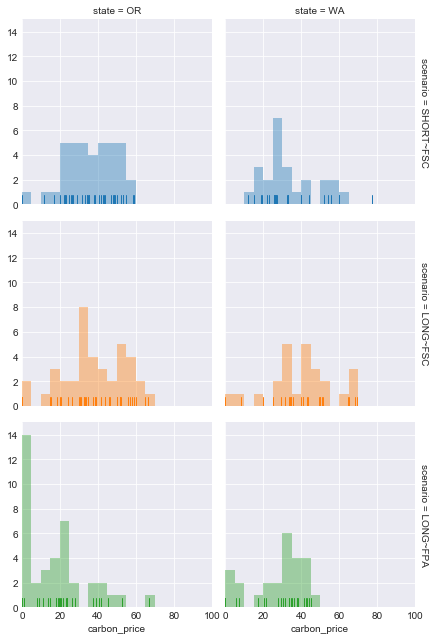

In [181]:
carbon_melt = pd.melt(carbon_values, id_vars=['state', 'parcel'], value_vars=['SHORT~FSC', 'LONG~FSC', 'LONG~FPA'], var_name='scenario', value_name='carbon_price')
g = sns.FacetGrid(carbon_melt, row='scenario', hue="scenario", col="state", margin_titles=True)
bins = np.arange(0,80,5)
g.map(sns.distplot, 'carbon_price', bins=bins, kde=False, rug=True, hist_kws={'density':False, 'normed':None})
plt.ylim(0,15)
plt.xlim(0,100);

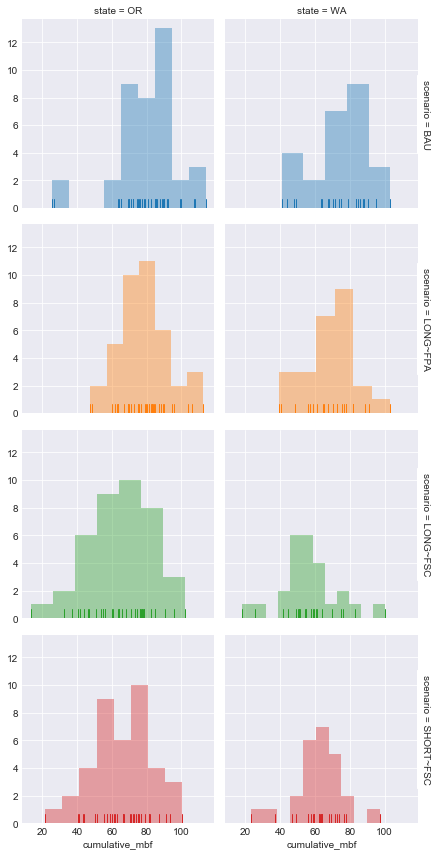

In [184]:
my_rx = all_rx.loc[['BAU', 'SHORT~FSC', 'LONG~FSC', 'LONG~FPA']]
g = sns.FacetGrid(my_rx.reset_index(), row='scenario', hue='scenario', col='state', margin_titles=True)
g.map(sns.distplot, 'cumulative_mbf', kde=False, rug=True, hist_kws={'density':False, 'normed':None});

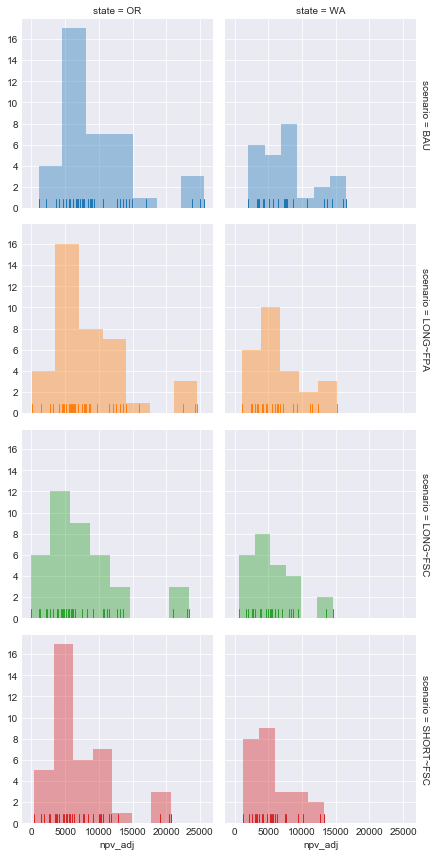

In [188]:
g = sns.FacetGrid(my_rx.reset_index(), row='scenario', hue="scenario", col="state", margin_titles=True)
g.map(sns.distplot, 'npv_adj', kde=False, rug=True, hist_kws={'density':False, 'normed':None});

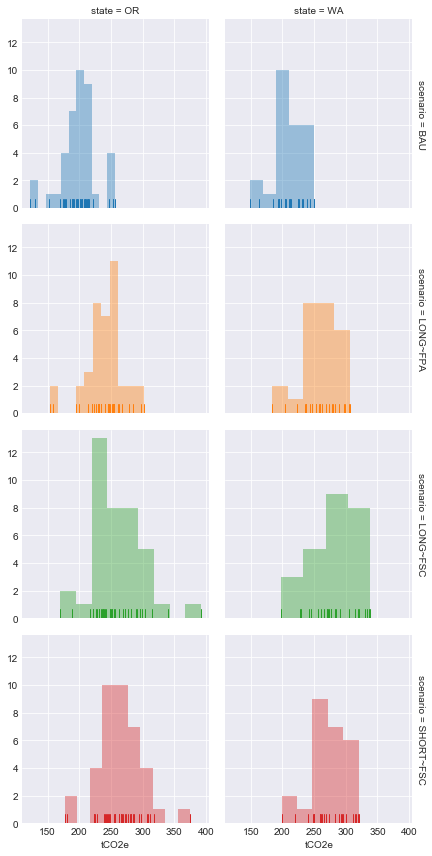

In [185]:
g = sns.FacetGrid(my_rx.reset_index(), row='scenario', hue="scenario", col="state", margin_titles=True)
g.map(sns.distplot, 'tCO2e', kde=False, rug=True, hist_kws={'density':False, 'normed':None});

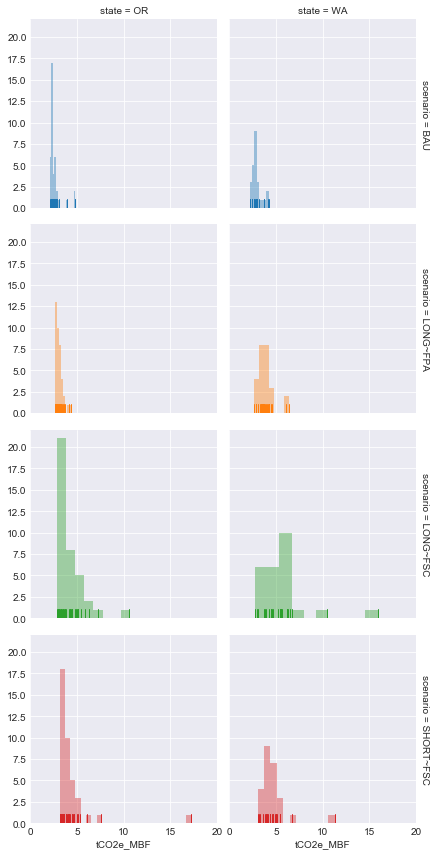

In [190]:
g = sns.FacetGrid(my_rx.reset_index(), row='scenario', hue="scenario", col="state", margin_titles=True)
g.map(sns.distplot, 'tCO2e_MBF', kde=False, rug=True, hist_kws={'density':False, 'normed':None})
plt.xlim(0,20);